<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%EC%A3%BC%ED%83%9D%EA%B0%80%EA%B2%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [309]:
import keras

In [310]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [311]:
print(train_data.shape, train_targets.shape, test_data.shape)

(404, 13) (404,) (102, 13)


In [312]:
from sklearn.model_selection import train_test_split

In [313]:
x_train, x_val, y_train, y_val = train_test_split(train_data, train_targets, test_size=0.2, random_state=42)

In [314]:
print(x_train.shape, x_val.shape)

(323, 13) (81, 13)


In [138]:
import numpy as np
x = np.concatenate([train_data, test_data])
y = np.concatenate([train_targets, test_targets])

In [139]:
print(x.shape, y.shape)

(506, 13) (506,)


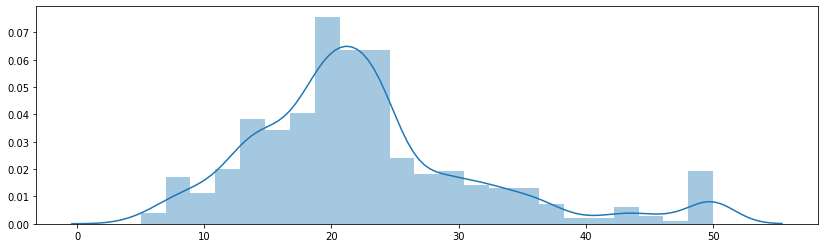

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(y)

In [315]:
np.mean(y) # 단위는 천달러

22.53280632411067

In [316]:
np.std(y)

9.188011545278203

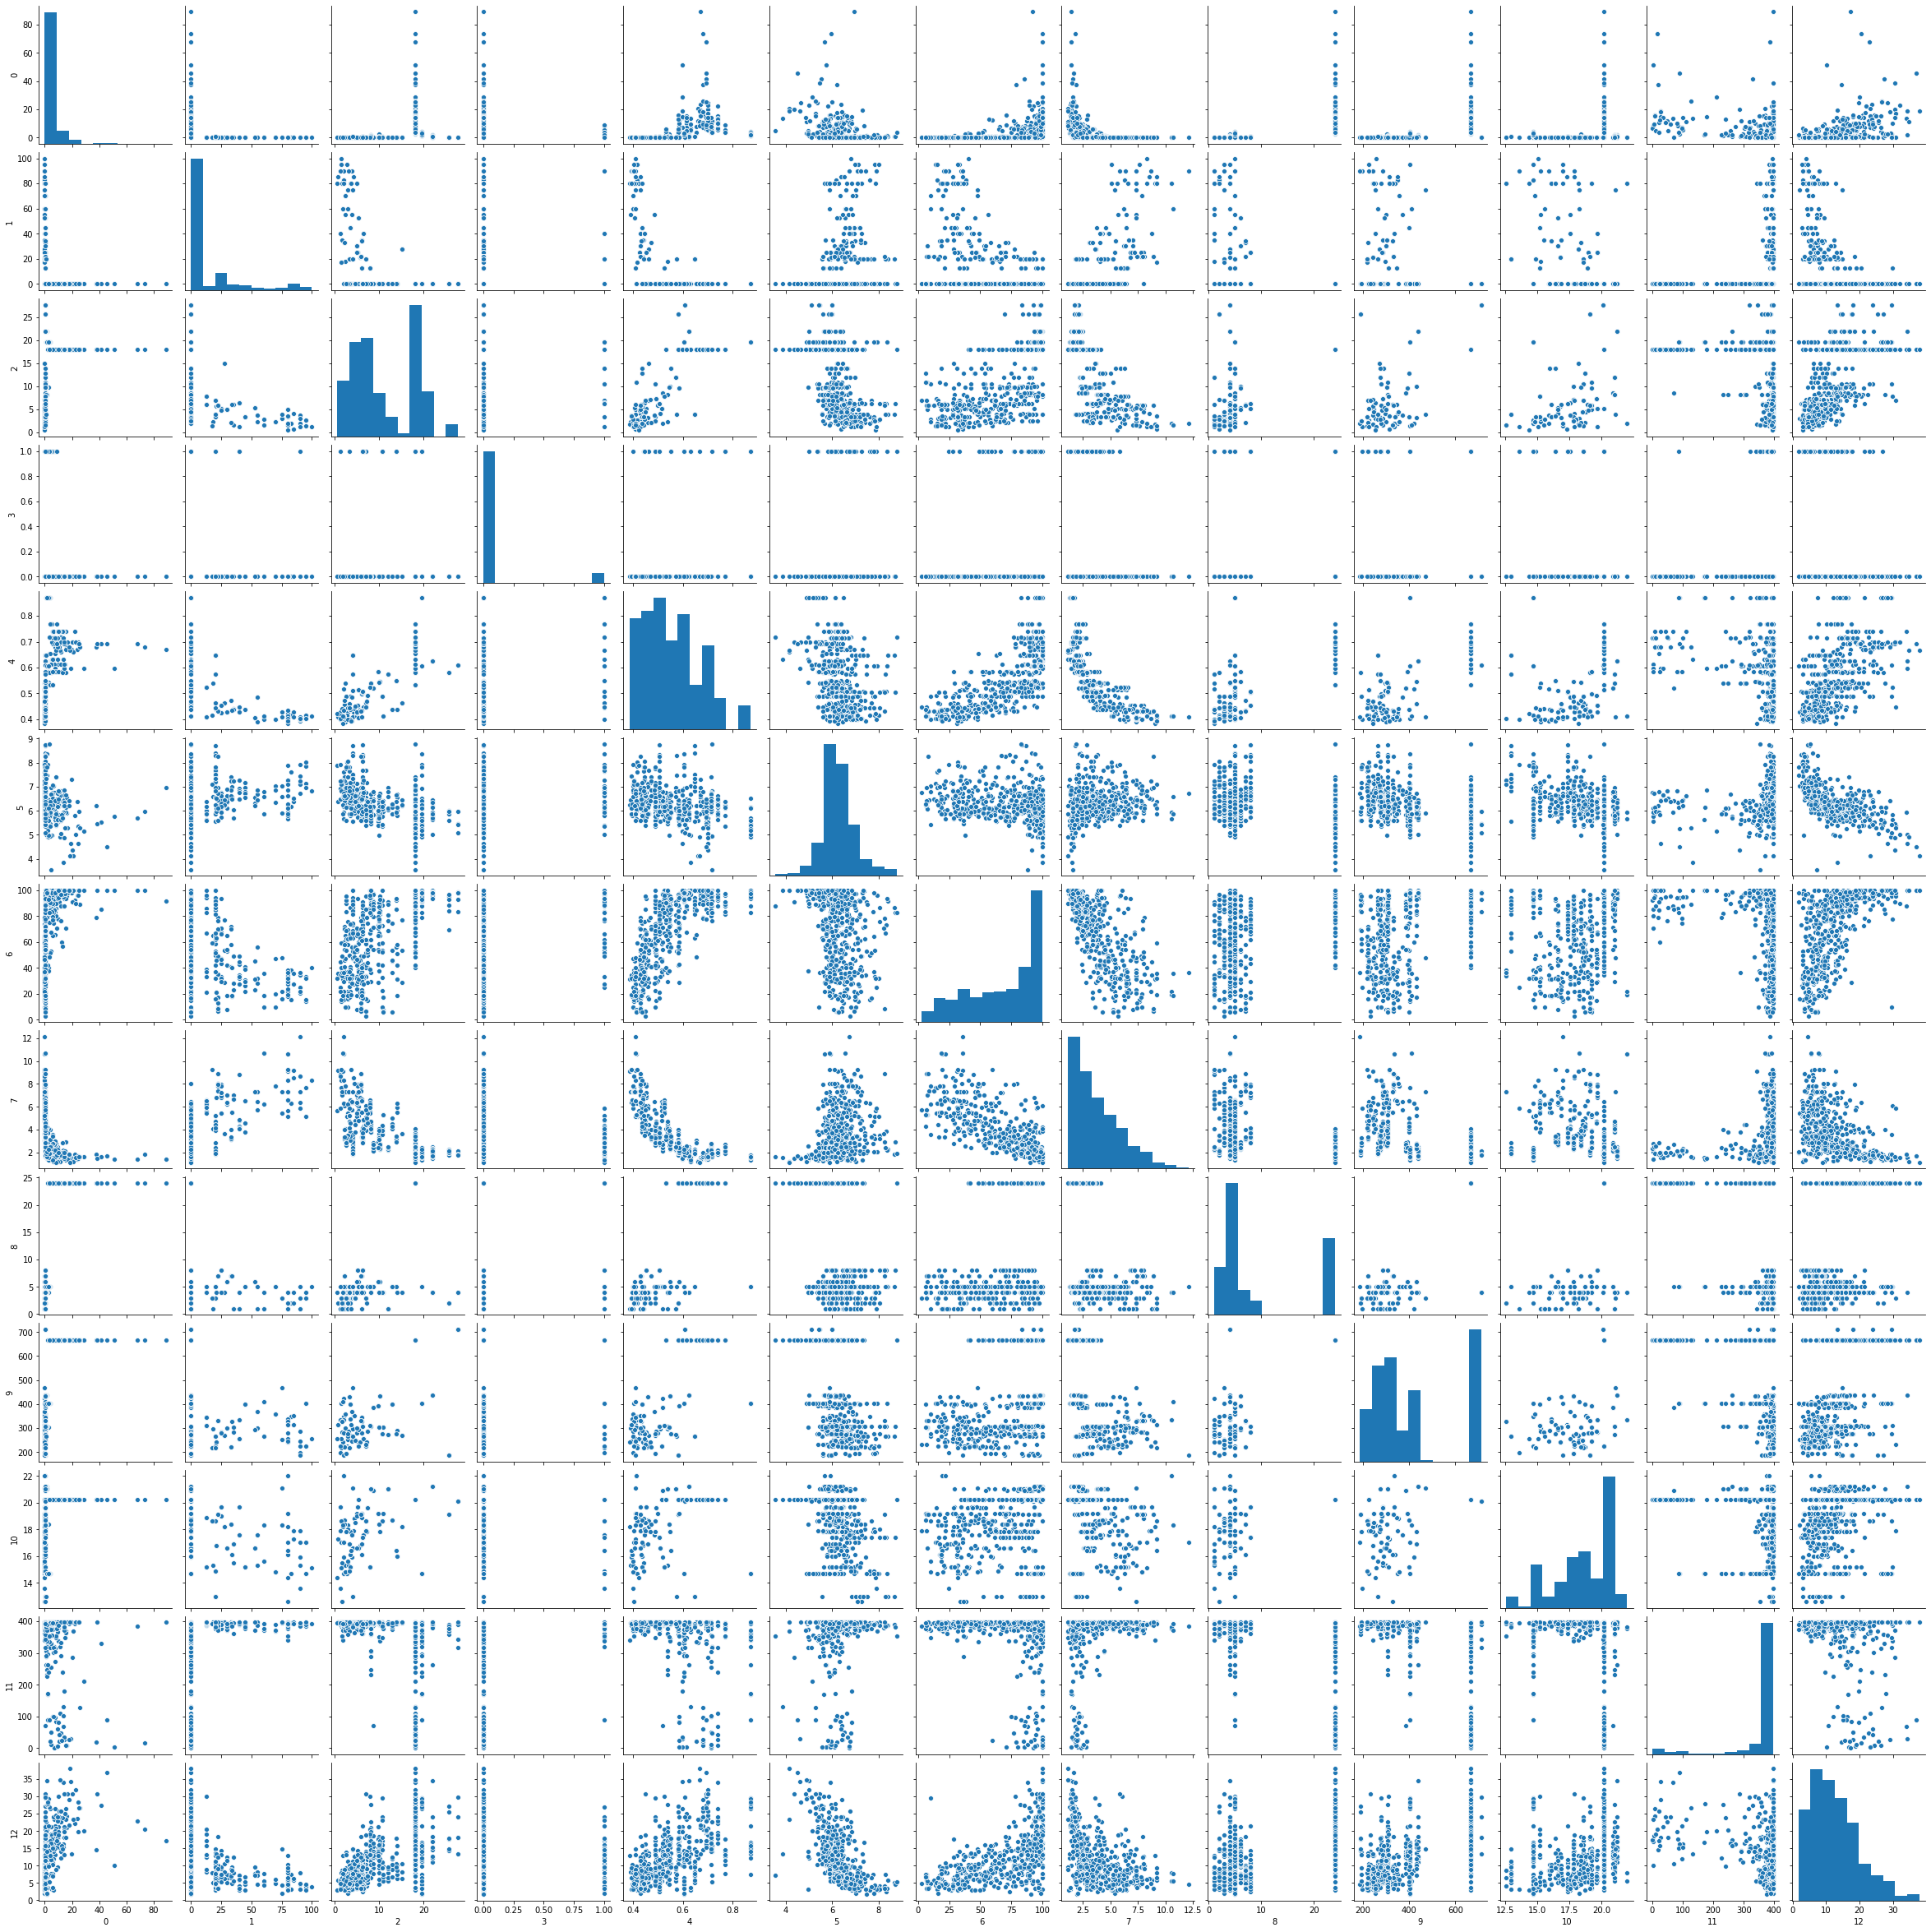

In [ ]:
import pandas as pd

df_x = pd.DataFrame(x)
sns.pairplot(df_x)
plt.show()

1) Per capita crime rate.
2) Proportion of residential land zoned for lots over 25,000 square feet.
3) Proportion of non-retail business acres per town.
4) Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5) Nitric oxides concentration (parts per 10 million).
6) Average number of rooms per dwelling.
7) Proportion of owner-occupied units built prior to 1940.
8) Weighted distances to five Boston employment centres.
9) Index of accessibility to radial highways.
10) Full-value property-tax rate per $10,000.
11) Pupil-teacher ratio by town.
12) 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13) % lower status of the population.

전처리 정규화에서 train과 test를 분리하고 train에서 산출된 평균과 표준편차로 Test set을 정규화 하였다. test 셋의 어떤 정보도 사전에 훈련과정에 반영시키지 않기 위함이다.

In [317]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

# Test data도 정규화를 해준다

x_val -= mean
x_val /= std

test_data -= mean
test_data /= std

In [318]:
from keras.models import Model
from keras import layers
from keras.layers import Dropout # Drop0ut을 사용한다.
from keras import Input
from keras import regularizers # 규제를 사용한다.
import tensorflow as tf

In [319]:
input_x = Input(shape=(13,)) # shape=(input_dim,)
middle_x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0))(input_x)
# middle_x = layers.Dropout(0.5)(middle_x)
middle_x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0))(middle_x)
output_y = layers.Dense(1, )(middle_x)
model = Model(input_x, output_y)
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 13)                0         
_________________________________________________________________
dense_163 (Dense)            (None, 64)                896       
_________________________________________________________________
dense_164 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [320]:
epochs_num = 100
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001), loss='mse', metrics=['mae'])
# 연속형 변수에서 mae 이다. 범주형이 아니므로 acc를 사용하기 어렵다

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs_num, verbose=0)
val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)

In [253]:
history_dic = history.history

In [254]:
history_dic.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

아래는 model.fit에 validation_data를 넣은 경우와 아닌 경우가 동일한지 테스트한 것이다.

In [321]:
print(history.history['val_mae'][-1])
print(val_mae)
print(history.history['val_loss'][-1])
print(val_mse)

2.554248571395874
2.554248571395874
12.000008736127688
12.000008736127688


In [150]:
import matplotlib.pyplot as plt

과적합이 발생할 경우, 1) 층 수 조정, 2) unit 축소, 3) 규제적용 등 
3가지 방법을 생각할 수 있으나 아래의 그림의 경우 과대, 과소적합 가능성이 매우 낮다

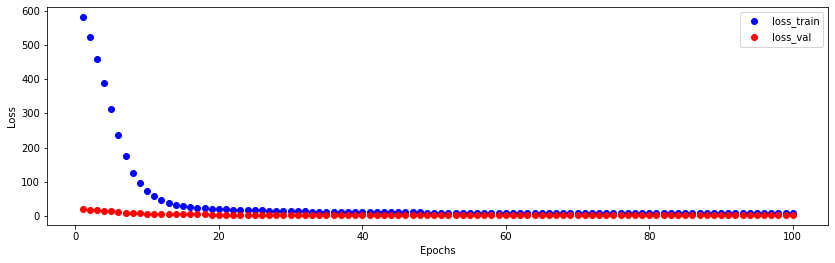

In [323]:
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], 'bo', label='loss_train')
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_mae'], 'ro', label='loss_val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

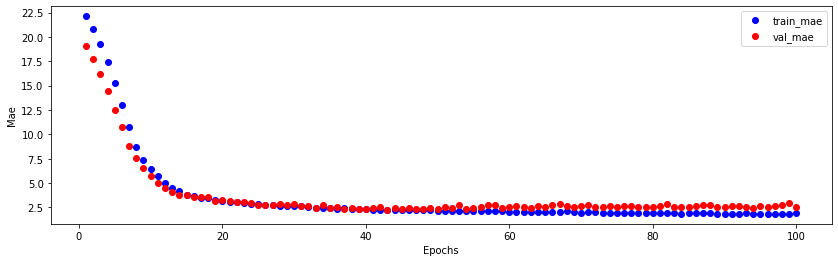

In [324]:
plt.plot(range(1, len(history.history['mae'])+1),history.history['mae'], 'bo', label='train_mae')
plt.plot(range(1, len(history.history['val_mae'])+1),history.history['val_mae'], 'ro', label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.show()

In [328]:
print(history.history['mae'][-1], history.history['val_mae'][-1])

1.8857397 2.554248571395874


샘플수가 작아서 모델을 평가하기 어렵다 검증데이터가 너무 작다. K겹 교차검증으로 모델을 평가하는 방법을 써야 한다. 이경우 반복문을 사용하므로 함수를 만들어서 모델을 적용해야 한다. 이것은 단지 모델의 구조를 검증하기 위한 방법이고, 검증을 마친 이후에 훈련데이터 전체를 사용해서 모델을 완성해야 한다

In [329]:
def build_model():
  input_x = Input(shape=(13,)) # shape=(input_dim,)
  middle_x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_x)
 # middle_x = layers.Dropout(0.5)(middle_x)
  middle_x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(middle_x)
  output_y = layers.Dense(1, )(middle_x)
  model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001), loss='mse', metrics=['mae'])
  return model

In [330]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
all_mae_histories = []
all_val_mae_histories = []
all_loss_histories = []
all_val_loss_histories = []

for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)
    val_mae_history = history.history['val_mae']
    all_val_mae_histories.append(val_mae_history)
    loss_history = history.history['loss']
    all_loss_histories.append(mae_history)
    val_loss_history = history.history['val_loss']
    all_val_loss_histories.append(val_mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [331]:
print(len(all_mae_histories),len(all_val_mae_histories),len(all_loss_histories),len(all_val_loss_histories))

4 4 4 4


In [332]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

average_val_mae_history = [
    np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

In [333]:
print(average_mae_history[-1],average_val_mae_history[-1])

2.8762767 3.364747166633606


In [334]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]

average_val_loss_history = [
    np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]



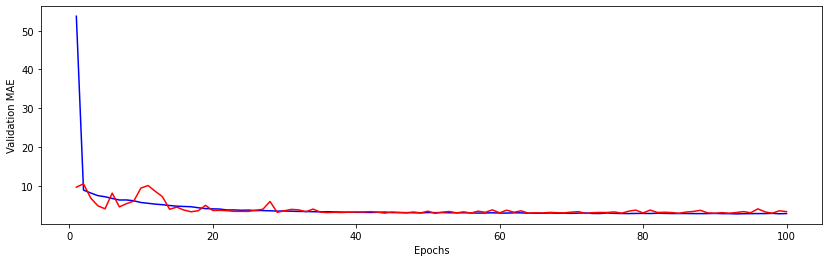

In [335]:
plt.rcParams["figure.figsize"] = (14,4)

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'b')
plt.plot(range(1, len(average_val_mae_history) + 1), average_val_mae_history, 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

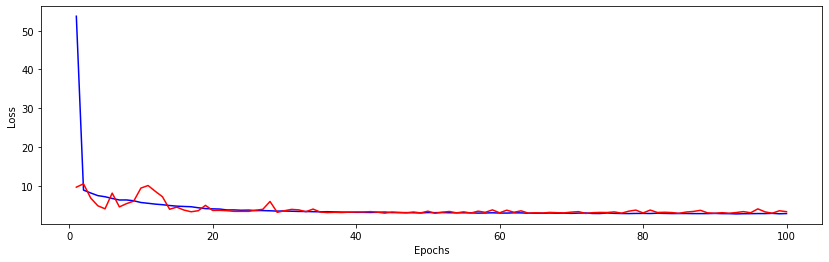

In [336]:
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, 'b')
plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [337]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

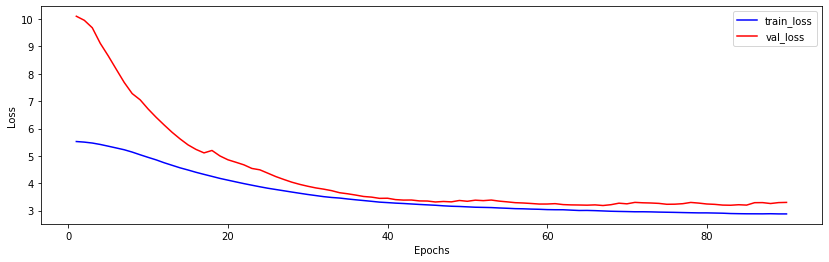

In [338]:
ma_loss= smooth_curve(average_loss_history[10:])
ma_val_loss= smooth_curve(average_val_loss_history[10:])

plt.plot(range(1, len(ma_mae) + 1), ma_loss, 'b', label='train_loss')
plt.plot(range(1, len(ma_val_mae) + 1), ma_val_loss, 'r', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

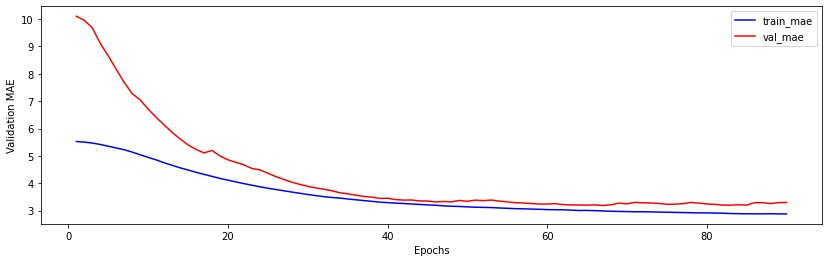

In [339]:
ma_mae= smooth_curve(average_mae_history[10:])
ma_val_mae= smooth_curve(average_val_mae_history[10:])

plt.plot(range(1, len(ma_mae) + 1), ma_mae, 'b', label='train_mae')
plt.plot(range(1, len(ma_val_mae) + 1), ma_val_mae, 'r', label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

위를 보면 약 10번 이상부터 과적합이 나타난 것을 알 수 있다.

In [ ]:
test_predicted = model.predict(test_data)

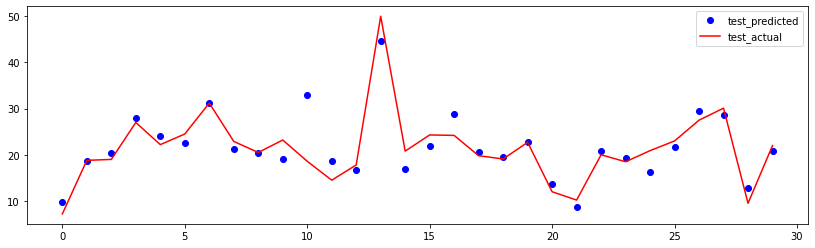

In [ ]:
plt.rcParams["figure.figsize"] = (14,4)

plt.plot(test_predicted[:30], 'bo', label='test_predicted')
plt.plot(test_targets[:30], 'r', label='test_actual')
plt.legend()
plt.show()

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [ ]:
all_scores

[2.2223737239837646, 2.509172201156616, 2.725677490234375, 2.307382822036743]

In [ ]:
np.mean(all_scores)

2.4411515593528748

In [ ]:
from keras import backend as K

# 메모리 해제
K.clear_session()

Using TensorFlow backend.


In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [ ]:
import matplotlib.pyplot as plt

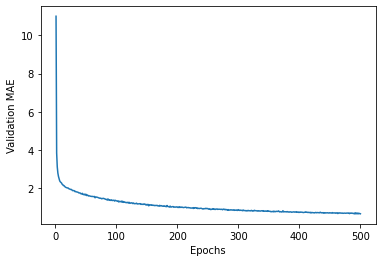

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

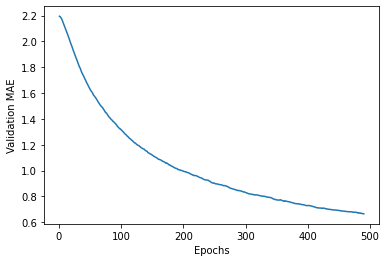

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
len(train_data)

404

In [ ]:
x_train_data = train_data[:202]
x_val_data = train_data[202:]
print(len(x_train_data), len(x_val_data))

202 202


In [ ]:
y_train_targets = train_targets[:202]
y_val_targets = train_targets[202:]
print(len(y_train_targets), len(y_val_targets))

202 202


In [ ]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
history = model.fit(x_train_data, y_train_targets, validation_data=(x_val_data, y_val_targets), epochs=100, batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 57us/step


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
iteration = range(1, len(loss)+1)

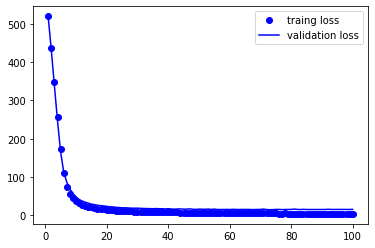

In [ ]:
plt.plot(iteration, loss, 'bo', label='traing loss')
plt.plot(iteration, val_loss, 'b', label='validation loss')
plt.legend()
plt.show()

In [ ]:
test_mae_score

3.0890331268310547

In [ ]:
y_predict = model.predict(x_train_data)
len(y_predict)

202

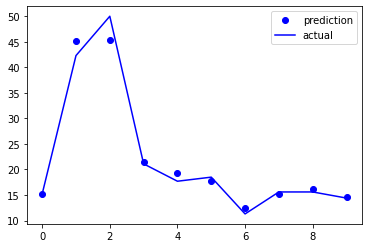

In [ ]:
plt.plot(y_predict[0:10], 'bo', label='prediction')
plt.plot(y_train_targets[0:10], 'b', label='actual')
plt.legend()
plt.show()

In [ ]:
test_predict = model.predict(test_data)
len(test_predict)

102

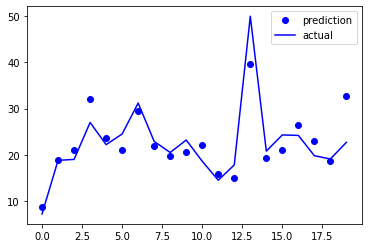

In [ ]:
plt.plot(test_predict[0:20], 'bo', label='prediction')
plt.plot(test_targets[0:20], 'b', label='actual')
plt.legend()
plt.show()